# Exercise 6: Protein sequence generation with transformers

In this exercise, you will delve into protein sequences, which are composed of amino acids. Understanding and predicting protein sequences is crucial in fields such as bioinformatics, drug discovery, and structural biology.

Generative pretraining using transformer-based models has proven to be a powerful approach for natural language understanding and generation tasks. In this exercise, we will adapt this approach to the domain of protein sequences. You will learn how to build a transformer model capable of predicting the next amino acid in a protein sequence and then train it on a dataset of protein sequences.

To do this, the following exercise is structured as follows:
1. Protein Sequences: load the data and explore it
2. Masked Self-Attention: implement masked self-attention
3. Transformer Model: build a small transformer model
4. Training: train a transformer model on the protein sequences to do *next-token prediction* (predict the next token, or "word", in a sequence)
5. Inference and Generation: use the trained model to generate new protein sequences

First, let's import some useful libraries. Note that you will have to write code in our custom modules!

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Import our custom modules
from data import *
from model import *
from train import *
from utils import *

device = torch.device("cpu" if torch.has_mps else "cpu")
print("Device:", device)

Device: cpu


## 1. Data: protein sequences

Our data is made of protein sequences, where each protein is described by a sequence of Amino Acids (AA). Each unique amino acid is represented by a unique letter of the [alphabet](https://www.bioinformatics.org/sms/iupac.html).

Download the data from [here](https://drive.google.com/file/d/1US0GzmJ2rcy4Uo0Kfo7KQOnPYoGIORCF/view?usp=drive_link), then extract it and load it below. 

The proteins are from eukaryotes, filtered to be of length 40-200 AA, and were originally taken from [UniProt](https://www.uniprot.org/).

In [2]:
sequences = load_json("data/sequences.json")

print(f"Number of protein sequences: {len(sequences)}")
print(f"A few examples:", *sequences[:4], sep="\n")

Number of protein sequences: 42980
A few examples:
MAFLKKSLFLVLFLGVVSLSFCEEEKREEHEEEKRDEEDAESLGKRYGGLSPLRISKRVPPGFTPFRSPARSISGLTPIRLSKRVPPGFTPFRSPARRISEADPGFTPSFVVIKGLSPLRGKRRPPGFSPFRVD
MKLSTSLLAIVAVASTFIGNALSATTVPGCFAECIDKAAVAVNCAAGDIDCLQASSQFATIVSECVATSDCTALSPGSASDADSINKTFNILSGLGFIDEADAFSAADVPEERDLTGLGRVLPVEKRQNCPTRRGLCVTSGLTACRNHCRSCHRGDVGCVRCSNAQCTGFLGTTCTCINPCPRC
MASSSVEFRCFVGGLAWATDSNSLEKAFSVYGEIVEAKIVSDRETGRSRGFGFVTFLEEEAMRSAIEAMNGHILDGRNITVNEAQQRGGGGGGGYNRGGGYGGRRDGGGFSRGGGGGYGGGGGGGYGGGRDRGYGGGGGYGGGRDSRGSGGGGSEGGWRN
MEIKYLLTVFLVLLIVSDHCQAFLFSLIPHAISGLISAFKGRRKRDLDGQIDRFRNFRKRDAELEELLSKLPIY


Min length: 40
Max length: 200


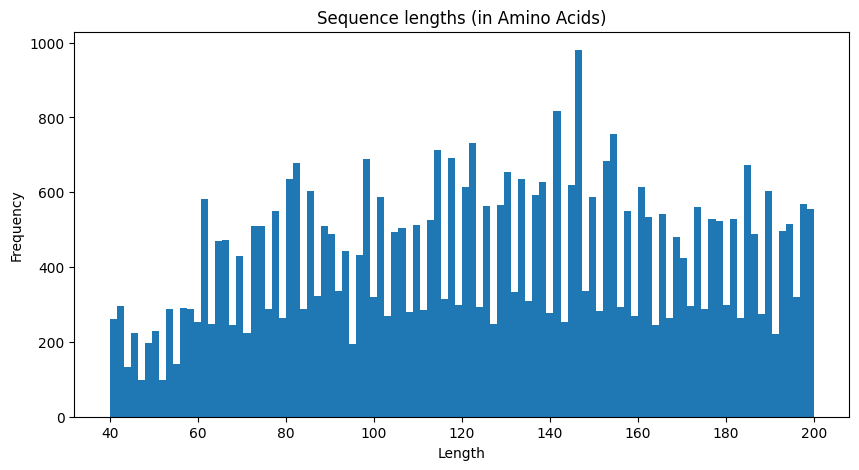

Number of different amino acids: 24
Total number of amino acids: 5,413,916


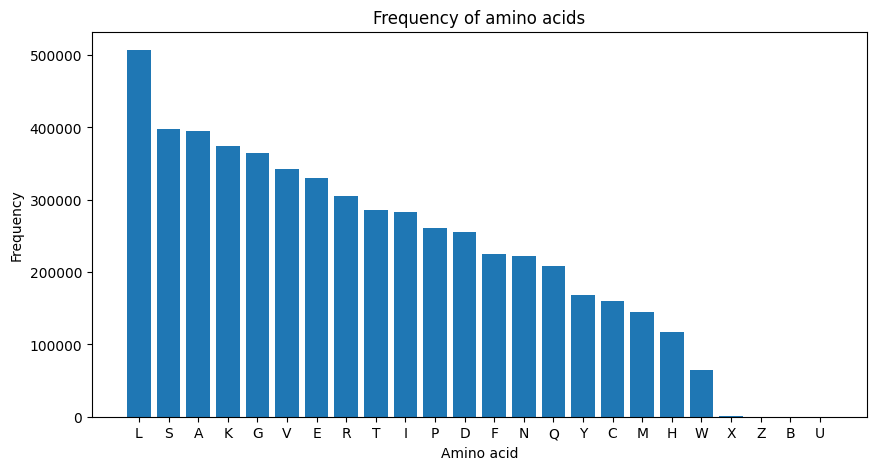

In [3]:
## Some data statistics
# Lengths of the sequences
seq_lens = [len(seq) for seq in sequences]
print(f"Min length: {min(seq_lens)}")
print(f"Max length: {max(seq_lens)}")

plt.figure(figsize=(10, 5))
plt.title("Sequence lengths (in Amino Acids)")
plt.hist(seq_lens, bins=100)
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

# Amino acids and frequencies
aa_freq = get_token_freq(sequences)
aa_sorted = sorted(aa_freq.keys(), key=lambda x: aa_freq[x], reverse=True)  # sorted by frequency
print(f"Number of different amino acids: {len(aa_freq)}")
print(f"Total number of amino acids: {sum(aa_freq.values()):,}")

plt.figure(figsize=(10, 5))
plt.title("Frequency of amino acids")
plt.bar(range(len(aa_freq)), [aa_freq[aa] for aa in aa_sorted], align="center", tick_label=aa_sorted)
plt.xlabel("Amino acid")
plt.ylabel("Frequency")
plt.show()

Now, we must prepare the vocabulary, *i.e.*, all possible tokens that the model can take as input and predict. To do this, we consider each unique amino acid as a token, and we also add a few special tokens `<bos>`, `<eos>`, `<pad>`:
* `<bos>`: begining of sequence. It is needed to generate the first AA, otherwise the initial input sequence would be empty!
* `<eos>`: end of sequence. It declares when a protein sequence ends, so that our model can predict sequences of different lengths.
* `<pad>`: padding token. It is used to indicate if a position is simply a padding instead of part of the sequence. It is useful to batch sequences of different length together, very similarly to batching images of different size.

In [4]:
# Build vocabulary by listing all amino acids (in order of frequency here), and adding the special tokens
vocab = ["<pad>", "<bos>", "<eos>"] + aa_sorted
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")
print(f"Vocabulary:", *vocab)

# Build mapping from token to indices (and vice-versa)
token2idx = {token: i for i, token in enumerate(vocab)}
idx2token = {i: token for i, token in enumerate(vocab)}

Vocabulary size: 27
Vocabulary: <pad> <bos> <eos> L S A K G V E R T I P D F N Q Y C M H W X Z B U


### 1.1. Implement a dataset

You are tasked with writing a PyTorch `Dataset` for the protein sequences. Fill in the `ProteinDataset` class as described in the `data.py` file.

**Note:** the input and target sequence should be shifted by one token: for positiong $i^{\mathrm{th}}$, we input the $i^{\mathrm{th}}$ token and want to predict the $i^{\mathrm{th}}+1$ token. For instance, consider the sentence "Quelle belle journée", with the added tokens `<bos>` and `<eos>`:

<img src="img/input_target.png" width="450" />

You can then use the following cells to test your implementation.

In [5]:
# Test the dataset
n_seq = 10
dataset = ProteinDataset(sequences[:n_seq], token2idx)
assert len(dataset) == n_seq

idx = 0
input_ids, target_ids = dataset[idx]
input_tokens, target_tokens = [idx2token[i] for i in input_ids], [idx2token[i] for i in target_ids]
print(f"Original sequence:                ", *sequences[idx])
print(f"Input sequence from dataset:", *input_tokens)
print(f"Target sequence from dataset:     ", *target_tokens)
assert input_tokens[0] == "<bos>" and target_tokens[-1] == "<eos>", "Did you add the special tokens?"
assert sequences[idx] == "".join(input_tokens[1:]) == "".join(target_tokens[:-1]), "The sequences are not equivalent."

Original sequence:                 M A F L K K S L F L V L F L G V V S L S F C E E E K R E E H E E E K R D E E D A E S L G K R Y G G L S P L R I S K R V P P G F T P F R S P A R S I S G L T P I R L S K R V P P G F T P F R S P A R R I S E A D P G F T P S F V V I K G L S P L R G K R R P P G F S P F R V D
Input sequence from dataset: <bos> M A F L K K S L F L V L F L G V V S L S F C E E E K R E E H E E E K R D E E D A E S L G K R Y G G L S P L R I S K R V P P G F T P F R S P A R S I S G L T P I R L S K R V P P G F T P F R S P A R R I S E A D P G F T P S F V V I K G L S P L R G K R R P P G F S P F R V D
Target sequence from dataset:      M A F L K K S L F L V L F L G V V S L S F C E E E K R E E H E E E K R D E E D A E S L G K R Y G G L S P L R I S K R V P P G F T P F R S P A R S I S G L T P I R L S K R V P P G F T P F R S P A R R I S E A D P G F T P S F V V I K G L S P L R G K R R P P G F S P F R V D <eos>


In [6]:
# Test the batch padding function with a dummy batch
batch = [
    [token2idx[i] for i in ['<bos>', 'A', 'B', 'C', '<eos>']],
    [token2idx[i] for i in ['<bos>', 'A', 'B', '<eos>']],
    [token2idx[i] for i in ['<bos>', 'A', '<eos>']],
    [token2idx[i] for i in ['<bos>', 'A', 'B', 'C', 'D', '<eos>']],
]
batch2 = [(b[:-1], b[1:]) for b in batch]
input_ids, target_ids = dataset.padding_batch(batch2)
assert input_ids.shape == target_ids.shape, "The input and target tensors should have the same shape."

# Do you obtain what you expect? Is the padding correct?
# Hint: all the inputs should start with <bos> and all targets should end with <eos> (except for the padding)
print("Input batch:")
print(*[[idx2token[i] for i in x] for x in input_ids.tolist()], sep="\n")
print("Target batch:")
print(*[[idx2token[i] for i in x] for x in target_ids.tolist()], sep="\n")
assert (input_ids[0] == torch.tensor([1, 5, 25, 19, 0])).all(), "The first input sequence is not correct."
assert (target_ids[0] == torch.tensor([5, 25, 19, 2, 0])).all(), "The first target sequence is not correct."

Input batch:
['<bos>', 'A', 'B', 'C', '<pad>']
['<bos>', 'A', 'B', '<pad>', '<pad>']
['<bos>', 'A', '<pad>', '<pad>', '<pad>']
['<bos>', 'A', 'B', 'C', 'D']
Target batch:
['A', 'B', 'C', '<eos>', '<pad>']
['A', 'B', '<eos>', '<pad>', '<pad>']
['A', '<eos>', '<pad>', '<pad>', '<pad>']
['A', 'B', 'C', 'D', '<eos>']


## 2. Transformer model

In this part, you will implement masked self-attention, a transformer layer, and finally a transformer network with these building blocks.

Let's first start with masking.

### 2.1. Masking

Recall from your lecture about the transformer decoder: when computing the self-attention, we do not want a given position to have access to the next position otherwise the model can simply cheat by looking at the next token to know what to predict!

Therefore, we will build a mask to hide these "future positions" when computing the attention.

<img src="img/attention_mask.png" width="350" />

Additionally, we will also mask the `<pad>` tokens as these are simply there to batch sequences together, but are not useful for our protein generation task.

Fill the function `get_mask()` in the file `utils.py`, and test it below.

In [7]:
# For a dummy input without any padding, test the masking function
input_ids = torch.ones(2, 5, dtype=torch.long).to(device)

# Compute the attention mask (no padding here). Do you obtain what you expect?
# Hint: the mask should be the same for each sequence of the batch (because there is no padding here)
mask = get_mask(input_ids, token2idx["<pad>"])
assert mask.shape == (2, 5, 5), "The mask should be of shape (batch_size, seq_len, seq_len)."
assert ((mask[0, 1]).to("cpu") == torch.BoolTensor([True, True, False, False, False])).all(), "The mask is not correct."

### 2.2. Masked self-attention

Now that we have a function to compute a mask, let's use it in the computation of the self-attention.

Here, you have to implement two modules:
1. `ScaledDotProductAttention`: implement masked self-attention, given queries, keys, and values $Q$, $K$, and $V$, and $d_k$ the dimension of these vectors:
$$
\mathrm{Attention}(Q,K,V)=\mathrm{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$
1. `SingleHeadAttention`: implement the full attention layer. Note: here we consider a **unique head** to simplify, so $h=1$, there is no concatenation, and the linear layers actually project from $d_k$ to $d_k$.

<img src="img/self-attention.png" width="600"/>

For the masking, the goal is to have an attention of $0$ for the masked position (where `mask==0`). A way of doing this is to replace the attention scores (pre-softmax) that are masked by $-\infty$, then they will become $0$ after we apply the exponential within the softmax!   
*Hint*: in python, you can use `float("-inf")` for $-\infty$.

You can find both class in `model.py`.

In [8]:
d_model = 4
attention = SingleHeadAttention(d_model).to(device)
q = torch.randn(2, 5, d_model).to(device)
k = torch.randn(2, 5, d_model).to(device)
v = torch.randn(2, 5, d_model).to(device)
output = attention(q, k, v, mask)
print(output.shape)
assert output.shape == (2, 5, d_model), "The output should be of shape (batch_size, seq_len, d_model)."

torch.Size([2, 5, 4])


### 2.3. Transformer layer

With the above module, write a transformer layer as shown below: (inputs enter at the bottom, outputs leave at the top)

<img src="img/transformer_layer.png" width="200" />

A few remarks:
1. the input `x` of the layer is used as query, key, and value for the `SingleHeadAttention` module,
2. for the feed-forward part, use two linear layers with a ReLU in between, the hidden dimension should be `feedforward_dim`
3. the dropout is applied after the attention and the feed-forward layers, but before the residual connection and layer norm.

Fill in the class `TransformerLayer` in `model.py`.

In [9]:
d_model = 4
feedforward_dim = 8
transformer_layer = TransformerLayer(d_model, feedforward_dim, 0.1).to(device)
input = torch.randn(2, 5, d_model).to(device)
output = transformer_layer(input)
print(output.shape)
assert output.shape == (2, 5, d_model), "The output should be of shape (batch_size, seq_len, d_model)."

torch.Size([2, 5, 4])


### 2.4. Model

Finally, let's implement a transformer model that we will train for next-token prediction.
This model will need:
1. Embedding layers: we need to embed both tokens and position. Here, we will use learnable embeddings for both, see [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).
2. Some transformer layers as defined before.
3. A final output layer to predict token probability **logits** at each position, we use a simple linear layer for this. **Note** that the softmax will not be part of the model, unlike the drawing below.

<img src="img/transformer.png" width="200" />

Fill in the `__init__()` and `forward()` function of the `Transformer` class in `model.py`. You can leave `generate_sequence()` for later.

**Note:** if you want to initialize a list of layers within a model, make sure to wrap them in a [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html), otherwise PyTorch will not find them correctly.

In [10]:
d_model = 4
feedforward_dim = 8
num_layers = 2
max_seq_len = 5
transformer = Transformer(vocab_size, token2idx['<pad>'], d_model, feedforward_dim, num_layers, 0.1, 
                          device, max_seq_len, token2idx, idx2token)
input_ids = torch.randint(3, 10, (2, 5), dtype=torch.long).to(device)
output = transformer(input_ids)
print(output.shape)
assert output.shape == (2, 5, vocab_size), "The output should be of shape (batch_size, seq_len, vocab_size)."

torch.Size([2, 5, 27])


## 3. Training

Let's now train our transformer to generate protein sequences!

We have implemented for you a training and evaluation function for you, in `train.py`. You can take a look to see how they work.

Below, you can choose between a `DEBUG` mode to use a small model and a subset of the data, or `FULL` to use the entire data and a larger model. We advise you to stay in debug when completing the exercise, and only do the full at home if you are interested (you will need a GPU for this, *e.g.*, Google Colab).

Note that in debug mode, we use only a few sequences. Therefore, you should expect that the model won't be able to generalize past the training set. In that mode, we advise you to simply try to overfit the training data to then see the generative capability of the model in what follows.

> Start Training (DEBUG mode)
Epoch: 1/100 - loss=3.1992 - ppl=24.5127 - acc=0.0626 - val-loss=2.9995 - val-ppl=20.0760 - val-acc: 0.0985 (0.49s/epoch)
Epoch: 2/100 - loss=2.9811 - ppl=19.7090 - acc=0.0933 - val-loss=2.9463 - val-ppl=19.0359 - val-acc: 0.1032 (0.46s/epoch)
Epoch: 3/100 - loss=2.9468 - ppl=19.0444 - acc=0.0914 - val-loss=2.9177 - val-ppl=18.4990 - val-acc: 0.1119 (0.45s/epoch)
Epoch: 4/100 - loss=2.9332 - ppl=18.7871 - acc=0.0972 - val-loss=2.9145 - val-ppl=18.4405 - val-acc: 0.1119 (0.47s/epoch)
Epoch: 5/100 - loss=2.9261 - ppl=18.6538 - acc=0.0946 - val-loss=2.9135 - val-ppl=18.4214 - val-acc: 0.1100 (0.52s/epoch)
Epoch: 6/100 - loss=2.9218 - ppl=18.5754 - acc=0.0980 - val-loss=2.9056 - val-ppl=18.2764 - val-acc: 0.1079 (0.50s/epoch)
Epoch: 7/100 - loss=2.9176 - ppl=18.4975 - acc=0.0998 - val-loss=2.9045 - val-ppl=18.2566 - val-acc: 0.1057 (0.49s/epoch)
Epoch: 8/100 - loss=2.9132 - ppl=18.4151 - acc=0.1035 - val-loss=2.9057 - val-ppl=18.2775 - val-acc: 0.1094 (0.47s/e

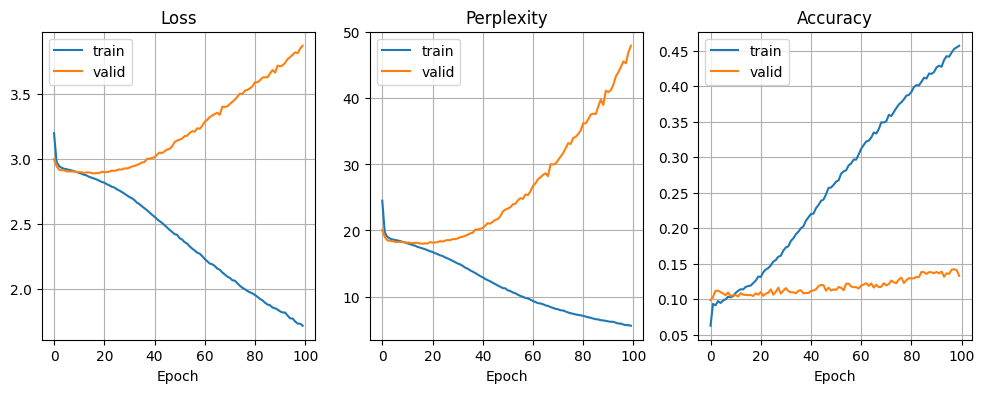

In [11]:
MAX_SEQ_LEN = 202  # maximum length of 200 AA + 2 for <bos> and <eos> tokens
TRAIN_RATIO = 0.8  # fraction of training samples
VALID_RATIO = 0.1  # fraction of validation samples (and rest is test)
MODE = "DEBUG"  # DEBUG or FULL. Use DEBUG to implement the exercise, you may try FULL on colab (with some time in front of you!)

# Hyperparameters
config = {
    "DEBUG": {  # you can expect ~40-50% acc on train with these hyperparameters (and ~10% on valid)
        "epochs": 100,
        "batch_size": 32,
        "subsample" : 250,  # number of sequences to subsample for faster training
        "lr": 1e-3,
        "d_model": 64,
        "feedforward_dim": 256,
        "num_layers": 3,
    },
    "FULL": {  # you may try these hyperparameters on colab (around ~1h30 for 50% acc on train and 35% on valid)
        "epochs": 100,
        "batch_size": 32,
        "subsample" : None,
        "lr": 1e-4,
        "d_model": 512,
        "feedforward_dim": 2048,
        "num_layers": 6,
    },
}

# Data
train_sequences, valid_sequences, test_sequences = split_sequences(
    sequences, TRAIN_RATIO, VALID_RATIO, subsample=config[MODE]["subsample"],
)
train_dataset = ProteinDataset(train_sequences, token2idx)
valid_dataset = ProteinDataset(valid_sequences, token2idx)
test_dataset = ProteinDataset(test_sequences, token2idx)
train_loader = DataLoader(train_dataset, batch_size=config[MODE]["batch_size"], shuffle=True, collate_fn=train_dataset.padding_batch)
valid_loader = DataLoader(valid_dataset, batch_size=config[MODE]["batch_size"], shuffle=False, collate_fn=valid_dataset.padding_batch)
test_loader = DataLoader(test_dataset, batch_size=config[MODE]["batch_size"], shuffle=False, collate_fn=test_dataset.padding_batch)

# Model
model = Transformer(
    vocab_size, 
    pad_idx=token2idx['<pad>'],
    d_model=config[MODE]["d_model"], 
    feedforward_dim=config[MODE]["feedforward_dim"], 
    num_layers=config[MODE]["num_layers"], 
    dropout=0.1, 
    device=device,
    max_seq_len=MAX_SEQ_LEN,
    token2idx=token2idx,
    idx2token=idx2token
)

# Optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=config[MODE]["lr"])
criterion = nn.CrossEntropyLoss(ignore_index=token2idx['<pad>']).to(device)  # ignore the padding in the loss computation

# Training loop
print(f"> Start Training ({MODE} mode)")
s = time.time()
history = training_loop(
    config[MODE]["epochs"], 
    model, 
    train_loader, 
    valid_loader, 
    criterion, 
    optimizer, 
    device, 
    token2idx['<pad>'], 
    vocab_size
)
print(f"> Finished Training ({time.time() - s:.2f}s)")

fig, axs = plt.subplots(1, 3,  figsize=(12, 4))
axs[0].set_title('Loss')
axs[0].plot(history['loss'], label='train')
axs[0].plot(history['val-loss'], label='valid')
axs[1].set_title('Perplexity')
axs[1].plot(history['ppl'], label='train')
axs[1].plot(history['val-ppl'], label='valid')
axs[2].set_title('Accuracy')
axs[2].plot(history['acc'], label='train')
axs[2].plot(history['val-acc'], label='valid')
for ax in axs.flat:
    ax.set(xlabel='Epoch')
    ax.grid()
    ax.legend();

Notes:
I had too minor bugs in the implementation which led to the model training way slower:
1. Applying dropout on the add & norm layer instead of just the output of the attention/ fc layer
2. Using a ReLU activation on the last layer of the fully connected layer in the Transformer block

It's crazy how these minor things have such a great effect on the final performance.

## 4. Evaluation

In this section, we explore what our model has learned and its ability to generate new sequences.

### 4.1. Visualize some next-token predictions

First, let's see some prediction results on example protein sequences from the train and validation sets. This is the same setting as in training: to predict a token at position $t$, the model sees all previous tokens up to position $t-1$.

In [12]:
# Compare the predictions of the model with the ground truth
model.eval()
for name, dataset in [("Training", train_dataset), ("Validation", valid_dataset)]:
    idx = np.random.choice(len(dataset))
    input_ids, target_ids = dataset[idx]
    with torch.no_grad():
        logits = model(torch.LongTensor([input_ids]).to(device))
    preds = torch.argmax(logits, dim=-1).squeeze(0).detach().cpu().numpy()
    print(f"\n{name} protein sequence {idx}:")
    print("  - Target:   ", " ".join([idx2token[i] for i in target_ids]))
    print("  - Predicted:", " ".join([idx2token[i] for i in preds]))
    print("  - Accuracy:", np.mean(preds == target_ids))


Training protein sequence 65:
  - Target:    M T Y A L F L L S V I L V M G F V G F S S K P S P I Y G G L V L I I S G A V G C A V I L N C G G G Y M G L M V F L I Y L G G M M V V F G Y T T A M A I E E Y P E A W G S G V E V L V S V L V G L V M E V G L V L W V K E Y D G V V V V V N F N S V G S W M I Y E G E G S G L I R E D P I G A G A L Y D Y G R W L V V V T G W T L F V G V Y V V I E I A R G N <eos>
  - Predicted: M A S A P L L L A V I L V M G L V G I S S K P S P I Y G L L F L I I S G V F G S V V I V N G G G G G G G L M M F L S Y L G G M V Y L I G V G G I M A M L V G K E E W G S D V G V F V G V Y N G L D M E V G L V L Q V R E V D G S V V V V N E L G V G S I M P Y E G C G S G L I R G D P I G A G L A V D S G L W L V V V G G W L L L V G V Y V V I V L A R G Y <eos>
  - Accuracy: 0.6457142857142857

Validation protein sequence 10:
  - Target:    M L S Q K P K K K H N F L N H G L S L N L V I K P Y L A L E G S V A F P A E N G V Q D T E S T Q E K R E T G D E E N S A K F P V G R R D F D T L S C M 

### 4.2. Generate new protein sequences

Our model can also be used as a purely generative model, *i.e.*, it can generate new sequences from scratch! To do this:
1. we initialize a sequence with the `<bos>` token
2. use the model to predict the next token
3. if the new predicted token is `<eos>`, or we have generated the maximum number of tokens, then the sequence is finished and we stop
4. else, append this new token to the input sequence and go back to step 2

Such a model that uses its previous output as input is called **auto-regressive**.

Implement the function `Transformer.generate_sequence()` in `model.py` to do this auto-regressive generation! We will choose the next token in a probabilistic way, by sampling it based on the predicted probabilities.

In [13]:
seq = model.generate_sequence()
print(f"Generated sequence of length {len(seq)}:")
print(*seq)

Generated sequence of length 127:
<bos> M A K G S F E F Q T S W L K V E D E K H N K S K M K T T D E E C E D K K D D A D I K L E Q I K L K S K K K M N D I K L F H V N I E K Q M N T K S P D N K F F A F K L N I I T K R T N D E E E K K E L N T I Q E E F I T N L D E E P F K V S K K K K S I A S <eos>


### 4.3. Test evaluation

Finally, let's see the model's performance on the unseen test set! (In the `DEBUG` mode, the performace might again be poor.)

In [14]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device, token2idx['<pad>'], vocab_size)
test_ppl = math.exp(test_loss)
print(f"Test loss={test_loss:.4f} - Test ppl={test_ppl:.4f} - Test acc={test_acc:.4f}")

Test loss=4.0393 - Test ppl=56.7874 - Test acc=0.1023
